#### Importing Required Libraries

In [ ]:
# For reproducibility with CuBLAS
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

In [ ]:
import re
import random
import textwrap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from tqdm import tqdm
from typing import List, Optional, Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, multilabel_confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
EE782   = '/content/drive/MyDrive/EE782'
os.makedirs(EE782, exist_ok=True)

In [ ]:
def set_seed(seed):

    # Numpy/Python RNGs
    random.seed(seed)
    np.random.seed(seed)

    # CPU/GPU RNGs
    torch.manual_seed(seed)  # RNG for CPU tensors
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # RNG for all GPU tensors

    # cuDNN determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

In [ ]:
SEED = 123   # 123, 999, etc.
set_seed(SEED)
print(f"Seed set to {SEED}")

Seed set to 123


#### CheXpert-v1.0-small(Kaggle)

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("ashery/chexpert")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chexpert' dataset.
Path to dataset files: /kaggle/input/chexpert


#### EDA of CheXpert-v1.0-small dataset

In [ ]:
!ls /kaggle/input/chexpert

train  train.csv  valid  valid.csv


In [ ]:
!ls /kaggle/input/chexpert/train

patient00001  patient12909  patient25817  patient38725	patient51633
patient00002  patient12910  patient25818  patient38726	patient51634
patient00003  patient12911  patient25819  patient38727	patient51635
patient00004  patient12912  patient25820  patient38728	patient51636
patient00005  patient12913  patient25821  patient38729	patient51637
patient00006  patient12914  patient25822  patient38730	patient51638
patient00007  patient12915  patient25823  patient38731	patient51639
patient00008  patient12916  patient25824  patient38732	patient51640
patient00009  patient12917  patient25825  patient38733	patient51641
patient00010  patient12918  patient25826  patient38734	patient51642
patient00011  patient12919  patient25827  patient38735	patient51643
patient00012  patient12920  patient25828  patient38736	patient51644
patient00013  patient12921  patient25829  patient38737	patient51645
patient00014  patient12922  patient25830  patient38738	patient51646
patient00015  patient12923  patient25831  patien

In [ ]:
!ls /kaggle/input/chexpert/train/patient00001

study1


In [ ]:
!ls /kaggle/input/chexpert/train/patient00001/study1

view1_frontal.jpg


In [ ]:
img_pth = '/kaggle/input/chexpert/train/patient00001/study1/view1_frontal.jpg'
img = cv2.imread(img_pth)
print(img.shape)

(320, 389, 3)


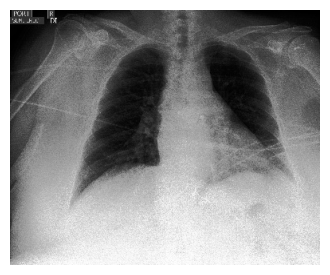

In [ ]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(4,4))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

#### Chexpert Data

In [ ]:
DATA_DIR  = '/kaggle/input/chexpert'
TRAIN_DIR = os.path.join(DATA_DIR,'train')
VALID_DIR = os.path.join(DATA_DIR,'valid')
TRAIN_CSV = os.path.join(DATA_DIR,'train.csv')
VALID_CSV = os.path.join(DATA_DIR,'valid.csv')

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
print(train_df.shape)
train_df.head()

(223414, 19)


Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
3         Lateral   NaN         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           NaN          NaN    NaN            NaN        NaN          NaN   
1           1.0          NaN   -1.0           -1.0        NaN         -1.0   
2           1.0          NaN    NaN           -1.0        NaN          NaN   
3           1.0          NaN    NaN           -1.0        NaN          NaN   
4           NaN          NaN    1.0            NaN        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               NaN            NaN       NaN              1.0  
1           NaN              -1.0            NaN       1.0              NaN  
2           NaN               NaN            NaN       1.0              NaN  
3           NaN               NaN            NaN       1.0              NaN  
4           0.0               NaN            NaN       NaN              NaN

In [ ]:
val_df = pd.read_csv(VALID_CSV)
print(val_df.shape)
val_df.head()

(234, 19)


Path     Sex  Age  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...    Male   73   
1  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
2  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
3  CheXpert-v1.0-small/valid/patient64543/study1/...    Male   85   
4  CheXpert-v1.0-small/valid/patient64544/study1/...  Female   42   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         0.0                         1.0           1.0   
1         Frontal    PA         0.0                         0.0           0.0   
2         Lateral   NaN         0.0                         0.0           0.0   
3         Frontal    AP         0.0                         1.0           0.0   
4         Frontal    AP         1.0                         0.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           1.0          0.0    0.0            0.0        0.0          0.0   
1           0.0          0.0    0.0            0.0        0.0          0.0   
2           0.0          0.0    0.0            0.0        0.0          0.0   
3           1.0          0.0    1.0            0.0        0.0          0.0   
4           0.0          0.0    0.0            0.0        0.0          0.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               0.0            0.0       0.0              0.0  
1           0.0               0.0            0.0       0.0              1.0  
2           0.0               0.0            0.0       0.0              1.0  
3           0.0               0.0            0.0       0.0              0.0  
4           0.0               0.0            0.0       0.0              0.0

#### Selecting Only Frontal Images (ignoring lateral images)

In [ ]:
train_df = train_df[train_df['Frontal/Lateral'] == 'Frontal']
print("After filtering frontal images:", len(train_df))

After filtering frontal images: 191027


In [ ]:
train_df.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   
5  CheXpert-v1.0-small/train/patient00004/study1/...  Female   20   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   
5         Frontal    PA         1.0                         0.0           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           NaN          NaN    NaN            NaN        NaN          NaN   
1           1.0          NaN   -1.0           -1.0        NaN         -1.0   
2           1.0          NaN    NaN           -1.0        NaN          NaN   
4           NaN          NaN    1.0            NaN        NaN          NaN   
5           NaN          NaN    NaN            0.0        NaN          NaN   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               NaN            NaN       NaN              1.0  
1           NaN              -1.0            NaN       1.0              NaN  
2           NaN               NaN            NaN       1.0              NaN  
4           0.0               NaN            NaN       NaN              NaN  
5           NaN               0.0            NaN       NaN              NaN

In [ ]:
val_df = val_df[val_df['Frontal/Lateral'] == 'Frontal']
print("After filtering frontal images:", len(val_df))

After filtering frontal images: 202


In [ ]:
val_df.head()

Path     Sex  Age  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...    Male   73   
1  CheXpert-v1.0-small/valid/patient64542/study1/...    Male   70   
3  CheXpert-v1.0-small/valid/patient64543/study1/...    Male   85   
4  CheXpert-v1.0-small/valid/patient64544/study1/...  Female   42   
5  CheXpert-v1.0-small/valid/patient64545/study1/...  Female   55   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         0.0                         1.0           1.0   
1         Frontal    PA         0.0                         0.0           0.0   
3         Frontal    AP         0.0                         1.0           0.0   
4         Frontal    AP         1.0                         0.0           0.0   
5         Frontal    AP         0.0                         1.0           0.0   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0           1.0          0.0    0.0            0.0        0.0          0.0   
1           0.0          0.0    0.0            0.0        0.0          0.0   
3           1.0          0.0    1.0            0.0        0.0          0.0   
4           0.0          0.0    0.0            0.0        0.0          0.0   
5           1.0          0.0    0.0            0.0        0.0          1.0   

   Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
0           0.0               0.0            0.0       0.0              0.0  
1           0.0               0.0            0.0       0.0              1.0  
3           0.0               0.0            0.0       0.0              0.0  
4           0.0               0.0            0.0       0.0              0.0  
5           0.0               1.0            0.0       0.0              0.0

#### Labels

In [ ]:
# canonical labels
canonical = [
    "No Finding",
    "Atelectasis",
    "Cardiomegaly",
    "Consolidation",
    "Edema",
    "Pleural Effusion",
    "Pneumonia",
    "Pneumothorax"]

In [ ]:
# mapping for CheXpert CSV columns -> CANONICAL
chexpert_to_canon = {
    "No Finding": "No Finding",
    "Atelectasis": "Atelectasis",
    "Cardiomegaly": "Cardiomegaly",
    "Lung Opacity": "Consolidation",    # unifying CheXpert "Lung Opacity" -> "Consolidation"
    "Edema": "Edema",
    "Pleural Effusion": "Pleural Effusion",
    "Pneumonia": "Pneumonia",
    "Pneumothorax": "Pneumothorax",
    "Consolidation": "Consolidation",
}

In [ ]:
# mapping for NIH ChestX-ray14 -> CANONICAL
nih_to_canon = {
    "No Finding": "No Finding",
    "Atelectasis": "Atelectasis",
    "Cardiomegaly": "Cardiomegaly",
    "Consolidation": "Consolidation",
    "Edema": "Edema",
    "Effusion": "Pleural Effusion",   # mapping NIH "Effusion" -> "Pleural Effusion"
    "Pneumonia": "Pneumonia",
    "Pneumothorax": "Pneumothorax",
    # NIH has many other columns (Mass, Nodule, Infiltration, etc.)
    # these are ignored or mapped to None (not used)
}

In [ ]:
def make_canonical_df(df_raw: pd.DataFrame, mapping: dict, canonical: list, path_col="Path"):
    out = pd.DataFrame()
    out["Path"] = df_raw[path_col].values

    for c in canonical:
        out[c] = 0.0
        out[c + "_mask"] = 0

    # group source columns that map to the same canonical target
    from collections import defaultdict
    grouped = defaultdict(list)
    for src_col, canon_col in mapping.items():
        grouped[canon_col].append(src_col)

    for canon_col, src_cols in grouped.items():
        for src_col in src_cols:
            if src_col not in df_raw.columns:
                continue
            vals = df_raw[src_col].values
            for i, v in enumerate(vals):
                if pd.isna(v) or float(v) == -1.0:
                    continue
                vv = float(v)
                # logical OR — if any mapped column has a positive finding, mark as positive
                if vv == 1.0:
                    out.at[i, canon_col] = 1.0
                # mark mask as valid if *any* mapped column has a valid value
                out.at[i, canon_col + "_mask"] = 1

    return out

#### Canonical DataFrames

In [ ]:
train_df_canon = make_canonical_df(train_df, chexpert_to_canon,canonical,"Path")

In [ ]:
train_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/train/patient00001/study1/...         1.0   
1  CheXpert-v1.0-small/train/patient00002/study2/...         0.0   
2  CheXpert-v1.0-small/train/patient00002/study1/...         0.0   
3  CheXpert-v1.0-small/train/patient00003/study1/...         0.0   
4  CheXpert-v1.0-small/train/patient00004/study1/...         1.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 0           0.0   
1                0          0.0                 0           0.0   
2                0          0.0                 0           0.0   
3                0          0.0                 0           0.0   
4                1          0.0                 0           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  0            0.0                   0    0.0           0   
1                  0            1.0                   1    0.0           0   
2                  0            1.0                   1    0.0           0   
3                  0            0.0                   0    1.0           1   
4                  0            0.0                   1    0.0           0   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      0        0.0               0   
1               0.0                      0        0.0               0   
2               0.0                      0        0.0               0   
3               0.0                      0        0.0               0   
4               0.0                      1        0.0               0   

   Pneumothorax  Pneumothorax_mask  
0           0.0                  1  
1           0.0                  0  
2           0.0                  0  
3           0.0                  1  
4           0.0                  0

In [ ]:
val_df_canon = make_canonical_df(val_df, chexpert_to_canon,canonical,"Path")

In [ ]:
val_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/valid/patient64541/study1/...         0.0   
1  CheXpert-v1.0-small/valid/patient64542/study1/...         0.0   
2  CheXpert-v1.0-small/valid/patient64543/study1/...         0.0   
3  CheXpert-v1.0-small/valid/patient64544/study1/...         1.0   
4  CheXpert-v1.0-small/valid/patient64545/study1/...         0.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 1           1.0   
1                1          0.0                 1           0.0   
2                1          0.0                 1           0.0   
3                1          0.0                 1           0.0   
4                1          1.0                 1           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  1            1.0                   1    0.0           1   
1                  1            0.0                   1    0.0           1   
2                  1            1.0                   1    1.0           1   
3                  1            0.0                   1    0.0           1   
4                  1            1.0                   1    0.0           1   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      1        0.0               1   
1               0.0                      1        0.0               1   
2               0.0                      1        0.0               1   
3               0.0                      1        0.0               1   
4               1.0                      1        0.0               1   

   Pneumothorax  Pneumothorax_mask  
0           0.0                  1  
1           0.0                  1  
2           0.0                  1  
3           0.0                  1  
4           0.0                  1

#### Patient wise splitting the data to prevent data leakage

In [ ]:
def extract_patient_id(path: str) -> str:
    """Extract patient identifier like 'patient00001' from a file path."""
    match = re.search(r"(patient\d+)", path)
    return match.group(1) if match else None

In [ ]:
train_df_canon["PatientID"] = train_df_canon["Path"].apply(extract_patient_id)

In [ ]:
train_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/train/patient00001/study1/...         1.0   
1  CheXpert-v1.0-small/train/patient00002/study2/...         0.0   
2  CheXpert-v1.0-small/train/patient00002/study1/...         0.0   
3  CheXpert-v1.0-small/train/patient00003/study1/...         0.0   
4  CheXpert-v1.0-small/train/patient00004/study1/...         1.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 0           0.0   
1                0          0.0                 0           0.0   
2                0          0.0                 0           0.0   
3                0          0.0                 0           0.0   
4                1          0.0                 0           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  0            0.0                   0    0.0           0   
1                  0            1.0                   1    0.0           0   
2                  0            1.0                   1    0.0           0   
3                  0            0.0                   0    1.0           1   
4                  0            0.0                   1    0.0           0   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      0        0.0               0   
1               0.0                      0        0.0               0   
2               0.0                      0        0.0               0   
3               0.0                      0        0.0               0   
4               0.0                      1        0.0               0   

   Pneumothorax  Pneumothorax_mask     PatientID  
0           0.0                  1  patient00001  
1           0.0                  0  patient00002  
2           0.0                  0  patient00002  
3           0.0                  1  patient00003  
4           0.0                  0  patient00004

* The "train" split of the dataset is split into (train + val) data
* The "valid" split of the dataset is considered as test data for evaluation

In [ ]:
# unique patient IDs
unique_patients = train_df_canon["PatientID"].unique()

train_patients, val_patients = train_test_split(
    unique_patients,
    test_size=0.15,      # 15% for validation
    random_state=SEED,
    shuffle=True
)

# assign split labels
train_df_canon["split"] = train_df_canon["PatientID"].apply(
    lambda x: "val" if x in val_patients else "train")

print(train_df_canon["split"].value_counts())

split
train    162595
val       28432
Name: count, dtype: int64


In [ ]:
train_df_canon.head()

Path  No Finding  \
0  CheXpert-v1.0-small/train/patient00001/study1/...         1.0   
1  CheXpert-v1.0-small/train/patient00002/study2/...         0.0   
2  CheXpert-v1.0-small/train/patient00002/study1/...         0.0   
3  CheXpert-v1.0-small/train/patient00003/study1/...         0.0   
4  CheXpert-v1.0-small/train/patient00004/study1/...         1.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 0           0.0   
1                0          0.0                 0           0.0   
2                0          0.0                 0           0.0   
3                0          0.0                 0           0.0   
4                1          0.0                 0           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  0            0.0                   0    0.0           0   
1                  0            1.0                   1    0.0           0   
2                  0            1.0                   1    0.0           0   
3                  0            0.0                   0    1.0           1   
4                  0            0.0                   1    0.0           0   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      0        0.0               0   
1               0.0                      0        0.0               0   
2               0.0                      0        0.0               0   
3               0.0                      0        0.0               0   
4               0.0                      1        0.0               0   

   Pneumothorax  Pneumothorax_mask     PatientID  split  
0           0.0                  1  patient00001  train  
1           0.0                  0  patient00002  train  
2           0.0                  0  patient00002  train  
3           0.0                  1  patient00003  train  
4           0.0                  0  patient00004  train

In [ ]:
train_data = train_df_canon[train_df_canon["split"] == "train"].reset_index(drop=True)
val_data   = train_df_canon[train_df_canon["split"] == "val"].reset_index(drop=True)
test_data  = val_df_canon

print(f"""Length of each split:
      Train: {len(train_data)}
      Val  : {len(val_data)}
      Test : {len(test_data)}""")

Length of each split:
      Train: 162595
      Val  : 28432
      Test : 202


In [ ]:
train_data_small = train_data.sample(frac=0.1, random_state=SEED).reset_index(drop=True)
val_data_small   = val_data.sample(frac=0.1, random_state=SEED).reset_index(drop=True)

#### Data Transforms

In [ ]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),     # RandomHorizontalFlip() uses torch.rand under the hood, global seed ensures reproducibilty
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # gray→RGB
    transforms.Normalize(mean= imagenet_mean,   # IMAGENET statistics
                         std = imagenet_std)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
   transforms.Normalize(mean= imagenet_mean,   # IMAGENET statistics
                        std = imagenet_std)
])

#### Custom Dataset Class

In [ ]:
class CheXpertDataset(Dataset):
    def __init__(self, df, transform=None, target_cols=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.target_cols = target_cols
        self.mask_cols = [c + "_mask" for c in target_cols]
        self.classes = target_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["Path"]
        correct_img_path = img_path.replace("CheXpert-v1.0-small",DATA_DIR)
        image = Image.open(correct_img_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row[self.target_cols].to_numpy(dtype=np.float32))
        mask = torch.tensor(row[self.mask_cols].to_numpy(dtype=np.float32))
        return image, label, mask

#### DataLoaders

In [ ]:
# Seed function for DataLoader workers
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
target_cols = canonical
train_dataset = CheXpertDataset(train_data_small,   train_transforms, target_cols)
val_dataset   = CheXpertDataset(val_data_small ,    val_transforms ,  target_cols)
chexpert_test_dataset  = CheXpertDataset(test_data, val_transforms ,  target_cols)

In [ ]:
# Generator for DataLoader
g = torch.Generator()
g.manual_seed(SEED)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

chexpert_test_loader = DataLoader(
    chexpert_test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

In [ ]:
img, label, mask = train_dataset[0]
print(type(img), img.shape)
print(type(label), label)

<class 'torch.Tensor'> torch.Size([3, 224, 224])
<class 'torch.Tensor'> tensor([0., 0., 0., 1., 0., 1., 0., 1.])


In [ ]:
images, labels, mask = next(iter(train_loader))
print(images.shape)   # [BATCH_SIZE, 3, 224, 224]
print(labels.shape)   # [BATCH_SIZE,num_classes]
print(mask.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 8])
torch.Size([32, 8])


#### Classfication Models

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

def build_resnet50(num_classes, pretrained=True):
  model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
  in_features = model.fc.in_features
  model.fc = nn.Linear(in_features, num_classes)
  return model

def build_densenet121(num_classes, pretrained=True):
  model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)
  in_features = model.classifier.in_features
  model.classifier = nn.Sequential(
      nn.Dropout(0.3),
      nn.Linear(in_features, num_classes))
  return model

def build_vit_b_16(num_classes, pretrained=True):
  model = models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None)
  in_features = model.heads.head.in_features
  model.heads.head = nn.Linear(in_features, num_classes)
  return model

def build_convnext(num_classes, pretrained=True):
  model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
  model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)
  return model

### Training

##### Helper Functions

In [ ]:
num_classes = len(canonical)
num_classes

8

In [ ]:
def masked_bce_loss(outputs, targets, masks, criterion):
    """
    Compute BCE loss while ignoring masked labels.

    outputs: (B, C) raw logits
    targets: (B, C) 0/1
    masks:   (B, C) 1=valid, 0=ignore
    """
    loss = criterion(outputs, targets)  # per-element
    loss = loss * masks                 # zero-out ignored labels
    valid = masks.sum()
    if valid == 0:
        return torch.tensor(0.0, device=outputs.device)
    return loss.sum() / valid

In [ ]:
def train(CHECKPOINT_DIR, model, train_loader, val_loader, criterion, optimizer, scheduler,
          num_epochs, resume_epoch=None, patience=5):
    start_epoch = 1
    best_val_acc = 0.0
    epochs_no_improve = 0

    metrics = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    # Resume training if requested
    if resume_epoch is not None:
        resume_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{resume_epoch-1}.pth")
        if os.path.exists(resume_path):
            checkpoint = torch.load(resume_path, map_location=device)
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            best_val_acc = checkpoint.get("best_val_acc", 0.0)
            start_epoch = resume_epoch
            print(f"Resuming from epoch {start_epoch} with best val acc {best_val_acc:.4f}")
        else:
            print(f"Checkpoint not found at {resume_path}, starting fresh.")

    for epoch in range(start_epoch, num_epochs + 1):
        print(f"----------------- Epoch {epoch} -----------------")

        # ---------- TRAIN ----------
        model.train()
        train_loss_total = 0.0
        train_corrects_total = 0.0
        total_train_labels = 0.0

        for images, labels, masks in tqdm(train_loader, desc=f"Train Epoch {epoch}"):
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = masked_bce_loss(outputs, labels, masks, criterion)
            loss.backward()
            optimizer.step()

            train_loss_total += loss.item() * masks.sum().item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            train_corrects_total += ((preds == labels) * masks).sum().item()
            total_train_labels += masks.sum().item()

        epoch_train_loss = train_loss_total / total_train_labels
        epoch_train_acc = train_corrects_total / total_train_labels

        metrics["train_loss"].append(epoch_train_loss)
        metrics["train_acc"].append(epoch_train_acc)
        print(f"Train Loss: {epoch_train_loss:.4f} | Train Accuracy: {epoch_train_acc:.4f}\n")

        # ---------- VALIDATION ----------
        model.eval()
        val_loss_total = 0.0
        val_corrects_total = 0.0
        total_val_labels = 0.0

        with torch.no_grad():
            for images, labels, masks in tqdm(val_loader, desc=f"Val Epoch {epoch}"):
                images, labels, masks = images.to(device), labels.to(device), masks.to(device)
                outputs = model(images)
                loss = masked_bce_loss(outputs, labels, masks, criterion)
                val_loss_total += loss.item() * masks.sum().item()

                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                val_corrects_total += ((preds == labels) * masks).sum().item()
                total_val_labels += masks.sum().item()

        epoch_val_loss = val_loss_total / total_val_labels
        epoch_val_acc = val_corrects_total / total_val_labels

        metrics["val_loss"].append(epoch_val_loss)
        metrics["val_acc"].append(epoch_val_acc)
        print(f"Validation Loss: {epoch_val_loss:.4f} | Validation Accuracy: {epoch_val_acc:.4f}\n")

        # ---------- CHECKPOINTING ----------
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch
            epochs_no_improve = 0

            best_ckpt_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
            torch.save({
                "best_epoch": best_epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": epoch_val_loss,
                "best_val_acc": best_val_acc,
                "metrics": metrics,
            }, best_ckpt_path)
            print(f"New best model saved at epoch {best_epoch} with val accuracy = {best_val_acc:.4f}\n")
        else:
            epochs_no_improve += 1

        # Save checkpoint for current epoch
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{epoch}.pth")
        torch.save({
            "epoch": epoch,
            "best_epoch": best_epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": epoch_val_loss,
            "best_val_acc": best_val_acc,
            "metrics": metrics,
        }, checkpoint_path)

        # ---------- EARLY STOPPING ----------
        if epochs_no_improve >= patience and epoch != num_epochs:
            print(f"\nEarly stopping. No improvement in {patience} epochs")
            break

        scheduler.step()

    print(f"\nTraining complete. Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
    return metrics

In [ ]:
def plot_train_val_acc(metrics):
  epochs = range(1, len(metrics['train_acc']) + 1)
  plt.figure(figsize=(5,3))
  plt.plot(epochs, metrics['train_acc'], label='Train Acc')
  plt.plot(epochs, metrics['val_acc'], label='Val Acc')
  plt.legend()
  plt.title('Accuracy vs Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.xticks(epochs)
  plt.show()

In [ ]:
def evaluate_model(model, test_loader, device, classes, threshold=0.5):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for images, labels, masks in test_loader:
            images, labels, masks = images.to(device), labels.to(device), masks.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            # Apply mask
            labels = labels * masks
            probs  = probs * masks
            preds  = preds * masks

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()

    print("------ Per-Class Metrics ------ ")
    per_class_auc, per_class_ap = [], []

    for i, cls in enumerate(classes):
        valid_idx = ~np.isnan(all_labels[:, i])
        if valid_idx.sum() == 0:
            continue
        try:
            auc = roc_auc_score(all_labels[valid_idx, i], all_probs[valid_idx, i])
        except ValueError:
            auc = np.nan
        ap = average_precision_score(all_labels[valid_idx, i], all_probs[valid_idx, i])
        per_class_auc.append(auc)
        per_class_ap.append(ap)
        print(f"{cls:20s} | AUC: {auc:.3f} | AP: {ap:.3f}")

    mean_auc = np.nanmean(per_class_auc)
    mean_ap = np.nanmean(per_class_ap)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')

    print("\n------ Summary ------ ")
    print(f"Mean AUC: {mean_auc:.3f}")
    print(f"Mean AP:  {mean_ap:.3f}")
    print(f"Macro F1: {macro_f1:.3f}")
    print(f"Micro F1: {micro_f1:.3f}")

In [ ]:
def visualize_predictions(model, test_loader, device, classes, num_images=12, fontsize=8):
    model.eval()
    plt.figure(figsize=(12, 6))
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std  = [0.229, 0.224, 0.225]

    all_images, all_labels = [], []

    # Collect a subset of images & labels
    with torch.no_grad():
        for images, labels, masks in test_loader:
            all_images.append(images)
            all_labels.append(labels)
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Pick random samples
    random_indices = random.sample(range(len(all_labels)), num_images)

    for i, idx in enumerate(random_indices):
        img = all_images[idx].to(device)
        label = all_labels[idx].to(device)

        outputs = model(img.unsqueeze(0))
        probs = torch.sigmoid(outputs)
        pred = (probs > 0.5).squeeze(0).cpu().numpy()
        true = label.cpu().numpy()

        true_labels = [classes[j] for j, v in enumerate(true) if v == 1]
        pred_labels = [classes[j] for j, v in enumerate(pred) if v == 1]

        # Unnormalize image
        img = img.cpu() * torch.tensor(imagenet_std)[:, None, None] + torch.tensor(imagenet_mean)[:, None, None]
        img = img.permute(1, 2, 0).numpy().clip(0, 1)

        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

        # Create wrapped label strings for clarity
        true_text = "T: " + ", ".join(true_labels) if true_labels else "T: None"
        pred_text = "P: " + ", ".join(pred_labels) if pred_labels else "P: None"
        wrapped_text = "\n".join(textwrap.wrap(true_text + " | " + pred_text, width=40))

        plt.text(0.5, -0.1, wrapped_text, fontsize=fontsize, ha='center', va='top', wrap=True, transform=plt.gca().transAxes)

    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)  # adds spacing between rows
    plt.show()

#### ResNet50

In [ ]:
resnet50_CHECKPOINT_DIR = os.path.join(EE782, f'resnet50_checkpoints_seed_{SEED}')
os.makedirs(resnet50_CHECKPOINT_DIR, exist_ok = True)
resnet50_CHECKPOINT_DIR

'/content/drive/MyDrive/EE782/resnet50_checkpoints_seed_123'

In [ ]:
def test_acc_best_model_resnet50(CHECKPOINT_DIR, num_classes, test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model      = build_resnet50(num_classes, False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()
  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_label_acc = test_corrects.double() / total_test_labels
  return test_label_acc, best_model

In [ ]:
def test_acc_ckpt_resnet50(CHECKPOINT_DIR,num_classes,test_loader,ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_resnet50(num_classes, False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds == labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels

  return test_acc, model

In [ ]:
resnet50_model    = build_resnet50(num_classes)
resnet50_model    = resnet50_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(resnet50_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train( resnet50_CHECKPOINT_DIR, resnet50_model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 509/509 [03:24<00:00,  2.49it/s]


Train Loss: 0.3418 | Train Accuracy: 0.8499



Val Epoch 1: 100%|██████████| 89/89 [00:31<00:00,  2.87it/s]


Validation Loss: 0.3195 | Validation Accuracy: 0.8634

New best model saved at epoch 1 with val accuracy = 0.8634

----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 509/509 [03:06<00:00,  2.73it/s]


Train Loss: 0.3012 | Train Accuracy: 0.8717



Val Epoch 2: 100%|██████████| 89/89 [00:14<00:00,  6.05it/s]


Validation Loss: 0.3161 | Validation Accuracy: 0.8612

----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 509/509 [03:06<00:00,  2.72it/s]


Train Loss: 0.2769 | Train Accuracy: 0.8831



Val Epoch 3: 100%|██████████| 89/89 [00:14<00:00,  6.07it/s]


Validation Loss: 0.3235 | Validation Accuracy: 0.8676

New best model saved at epoch 3 with val accuracy = 0.8676

----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 509/509 [03:07<00:00,  2.72it/s]


Train Loss: 0.2430 | Train Accuracy: 0.9013



Val Epoch 4: 100%|██████████| 89/89 [00:14<00:00,  6.05it/s]


Validation Loss: 0.3385 | Validation Accuracy: 0.8641

----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 509/509 [03:07<00:00,  2.72it/s]


Train Loss: 0.2043 | Train Accuracy: 0.9198



Val Epoch 5: 100%|██████████| 89/89 [00:14<00:00,  5.95it/s]


Validation Loss: 0.3451 | Validation Accuracy: 0.8635

----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 509/509 [03:07<00:00,  2.72it/s]


Train Loss: 0.1550 | Train Accuracy: 0.9411



Val Epoch 6: 100%|██████████| 89/89 [00:14<00:00,  5.95it/s]


Validation Loss: 0.3994 | Validation Accuracy: 0.8582

----------------- Epoch 7 -----------------


Train Epoch 7: 100%|██████████| 509/509 [03:07<00:00,  2.72it/s]


Train Loss: 0.1174 | Train Accuracy: 0.9563



Val Epoch 7: 100%|██████████| 89/89 [00:14<00:00,  5.98it/s]


Validation Loss: 0.4824 | Validation Accuracy: 0.8556

----------------- Epoch 8 -----------------


Train Epoch 8: 100%|██████████| 509/509 [03:07<00:00,  2.72it/s]


Train Loss: 0.0833 | Train Accuracy: 0.9703



Val Epoch 8: 100%|██████████| 89/89 [00:15<00:00,  5.84it/s]


Validation Loss: 0.4809 | Validation Accuracy: 0.8624


Early stopping. No improvement in 5 epochs

Training complete. Best validation accuracy: 0.8676 at epoch 3


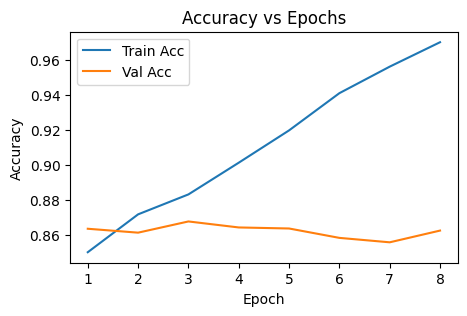

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_resnet50(resnet50_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 3 with val acc = 0.8676
Test Label-wise Accuracy: 53.5891 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.861 | AP: 0.519
Atelectasis          | AUC: 0.754 | AP: 0.596
Cardiomegaly         | AUC: 0.745 | AP: 0.536
Consolidation        | AUC: 0.876 | AP: 0.901
Edema                | AUC: 0.886 | AP: 0.699
Pleural Effusion     | AUC: 0.901 | AP: 0.837
Pneumonia            | AUC: 0.820 | AP: 0.201
Pneumothorax         | AUC: 0.688 | AP: 0.196

------ Summary ------ 
Mean AUC: 0.816
Mean AP:  0.560
Macro F1: 0.442
Micro F1: 0.506


We reproduce a ResNet-50 baseline on CheXpert using masked BCE loss and report AUC = 0.825

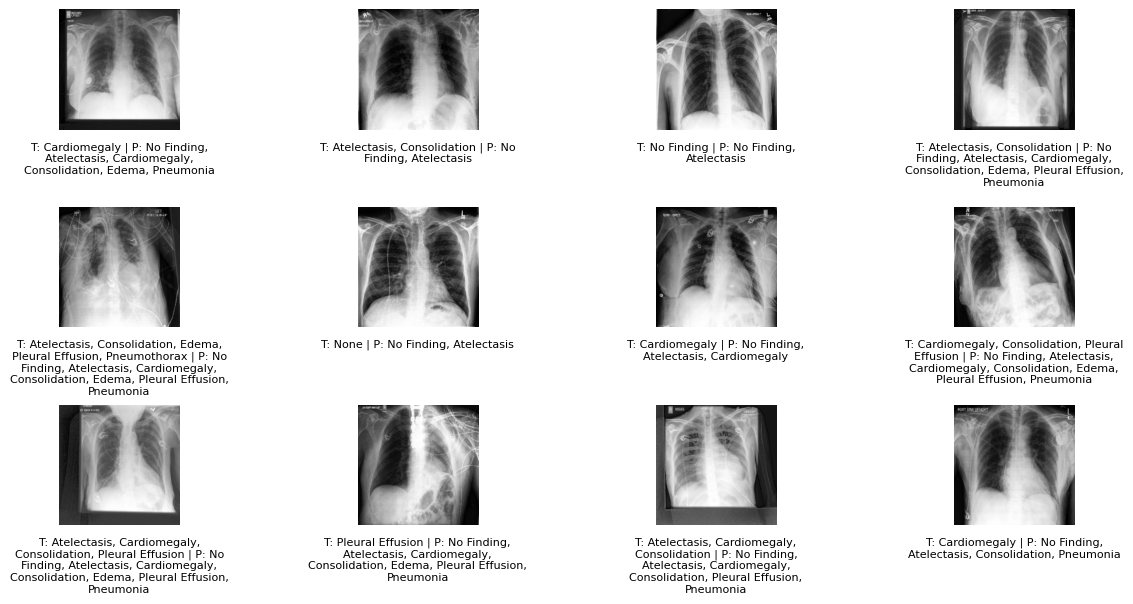

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=12)

---

In [ ]:
t2, ckpt_model= test_acc_ckpt_resnet50(resnet50_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=8)
print(f"Test Label-wise Accuracy: {t2*100:.4f} %")

Loaded model from epoch 8
Test Label-wise Accuracy: 57.5495 %


In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.737 | AP: 0.344
Atelectasis          | AUC: 0.753 | AP: 0.642
Cardiomegaly         | AUC: 0.790 | AP: 0.636
Consolidation        | AUC: 0.866 | AP: 0.904
Edema                | AUC: 0.859 | AP: 0.642
Pleural Effusion     | AUC: 0.902 | AP: 0.821
Pneumonia            | AUC: 0.776 | AP: 0.140
Pneumothorax         | AUC: 0.760 | AP: 0.306

------ Summary ------ 
Mean AUC: 0.805
Mean AP:  0.554
Macro F1: 0.471
Micro F1: 0.519


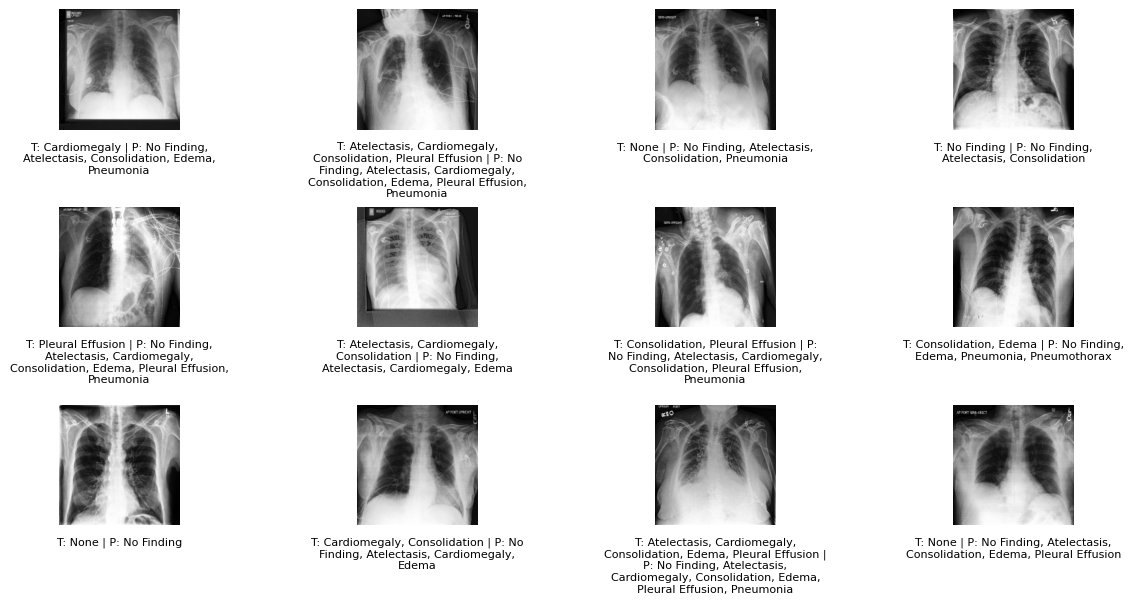

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

#### DenseNet121

In [ ]:
def test_acc_best_model_densenet121(CHECKPOINT_DIR, num_classes, test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model = build_densenet121(num_classes,False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()
  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")

  # Testing
  test_corrects,total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc , best_model

In [ ]:
def test_acc_ckpt_densenet121(CHECKPOINT_DIR, num_classes, test_loader, ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_densenet121(num_classes,False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in chexpert_test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds == labels)*masks).sum()
          total_test_labels  += masks.sum()

  test_acc = test_corrects.double() /  total_test_labels

  return test_acc, model

In [ ]:
densenet121_CHECKPOINT_DIR = os.path.join(EE782, f'densenet121_checkpoints_seed_{SEED}')
os.makedirs(densenet121_CHECKPOINT_DIR, exist_ok=True)

In [ ]:
densenet121_model = build_densenet121(num_classes)
densenet121_model = densenet121_model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 208MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(densenet121_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train(densenet121_CHECKPOINT_DIR, densenet121_model, train_loader, val_loader,criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 509/509 [02:53<00:00,  2.94it/s]


Train Loss: 0.3619 | Train Accuracy: 0.8378



Val Epoch 1: 100%|██████████| 89/89 [00:15<00:00,  5.89it/s]


Validation Loss: 0.3208 | Validation Accuracy: 0.8650

New best model saved at epoch 1 with val accuracy = 0.8650

----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 509/509 [02:54<00:00,  2.91it/s]


Train Loss: 0.3012 | Train Accuracy: 0.8712



Val Epoch 2: 100%|██████████| 89/89 [00:15<00:00,  5.64it/s]


Validation Loss: 0.3137 | Validation Accuracy: 0.8685

New best model saved at epoch 2 with val accuracy = 0.8685

----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 509/509 [02:58<00:00,  2.86it/s]


Train Loss: 0.2765 | Train Accuracy: 0.8841



Val Epoch 3: 100%|██████████| 89/89 [00:15<00:00,  5.80it/s]


Validation Loss: 0.3091 | Validation Accuracy: 0.8689

New best model saved at epoch 3 with val accuracy = 0.8689

----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 509/509 [02:59<00:00,  2.84it/s]


Train Loss: 0.2460 | Train Accuracy: 0.8984



Val Epoch 4: 100%|██████████| 89/89 [00:14<00:00,  5.97it/s]


Validation Loss: 0.3248 | Validation Accuracy: 0.8610

----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 509/509 [02:56<00:00,  2.88it/s]


Train Loss: 0.2111 | Train Accuracy: 0.9154



Val Epoch 5: 100%|██████████| 89/89 [00:14<00:00,  6.11it/s]


Validation Loss: 0.3432 | Validation Accuracy: 0.8630

----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 509/509 [02:56<00:00,  2.89it/s]


Train Loss: 0.1750 | Train Accuracy: 0.9314



Val Epoch 6: 100%|██████████| 89/89 [00:14<00:00,  6.10it/s]


Validation Loss: 0.3860 | Validation Accuracy: 0.8395

----------------- Epoch 7 -----------------


Train Epoch 7: 100%|██████████| 509/509 [02:56<00:00,  2.88it/s]


Train Loss: 0.1309 | Train Accuracy: 0.9509



Val Epoch 7: 100%|██████████| 89/89 [00:14<00:00,  6.05it/s]


Validation Loss: 0.3801 | Validation Accuracy: 0.8586

----------------- Epoch 8 -----------------


Train Epoch 8: 100%|██████████| 509/509 [02:56<00:00,  2.88it/s]


Train Loss: 0.0991 | Train Accuracy: 0.9645



Val Epoch 8: 100%|██████████| 89/89 [00:14<00:00,  6.02it/s]


Validation Loss: 0.4362 | Validation Accuracy: 0.8528


Early stopping. No improvement in 5 epochs

Training complete. Best validation accuracy: 0.8689 at epoch 3


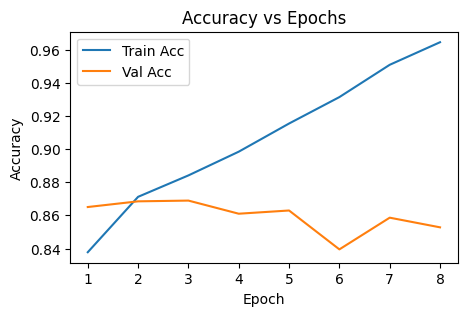

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_densenet121(densenet121_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 3 with val acc = 0.8689
Test Label-wise Accuracy: 53.7129 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.688 | AP: 0.238
Atelectasis          | AUC: 0.724 | AP: 0.553
Cardiomegaly         | AUC: 0.826 | AP: 0.669
Consolidation        | AUC: 0.875 | AP: 0.906
Edema                | AUC: 0.903 | AP: 0.792
Pleural Effusion     | AUC: 0.899 | AP: 0.819
Pneumonia            | AUC: 0.863 | AP: 0.271
Pneumothorax         | AUC: 0.703 | AP: 0.101

------ Summary ------ 
Mean AUC: 0.810
Mean AP:  0.543
Macro F1: 0.452
Micro F1: 0.505


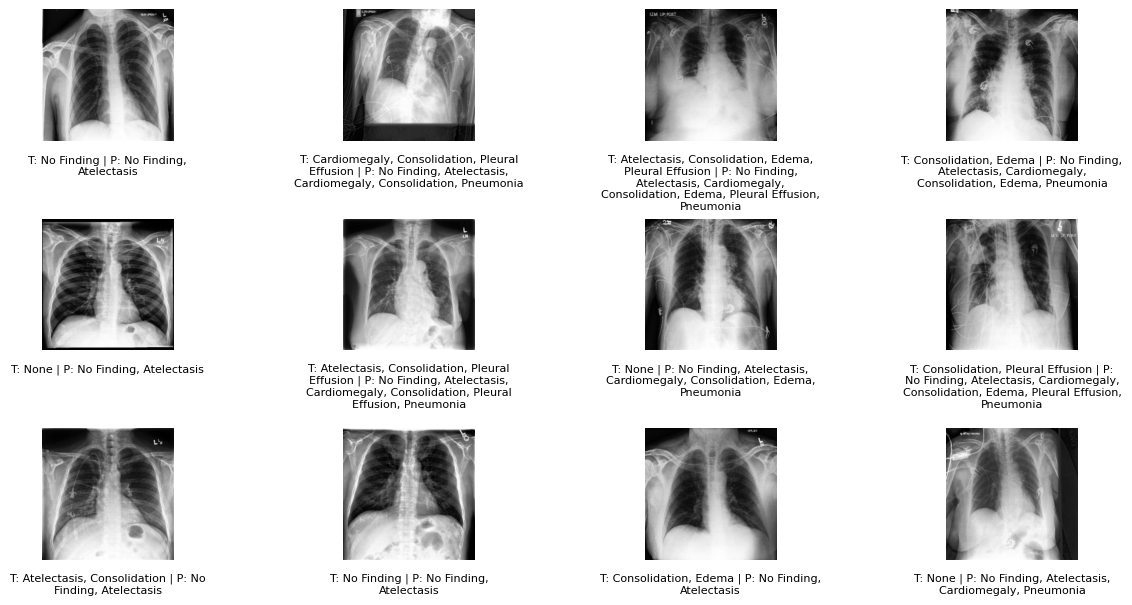

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=12)

---

In [ ]:
t2, ckpt_model = test_acc_ckpt_densenet121(densenet121_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=8)
print(f"Test Label-wise Accuracy: {t2*100:.4f} %")

Loaded model from epoch 8
Test Label-wise Accuracy: 55.1980 %


In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.703 | AP: 0.267
Atelectasis          | AUC: 0.793 | AP: 0.648
Cardiomegaly         | AUC: 0.778 | AP: 0.588
Consolidation        | AUC: 0.838 | AP: 0.868
Edema                | AUC: 0.849 | AP: 0.624
Pleural Effusion     | AUC: 0.884 | AP: 0.773
Pneumonia            | AUC: 0.848 | AP: 0.338
Pneumothorax         | AUC: 0.730 | AP: 0.221

------ Summary ------ 
Mean AUC: 0.803
Mean AP:  0.541
Macro F1: 0.448
Micro F1: 0.506


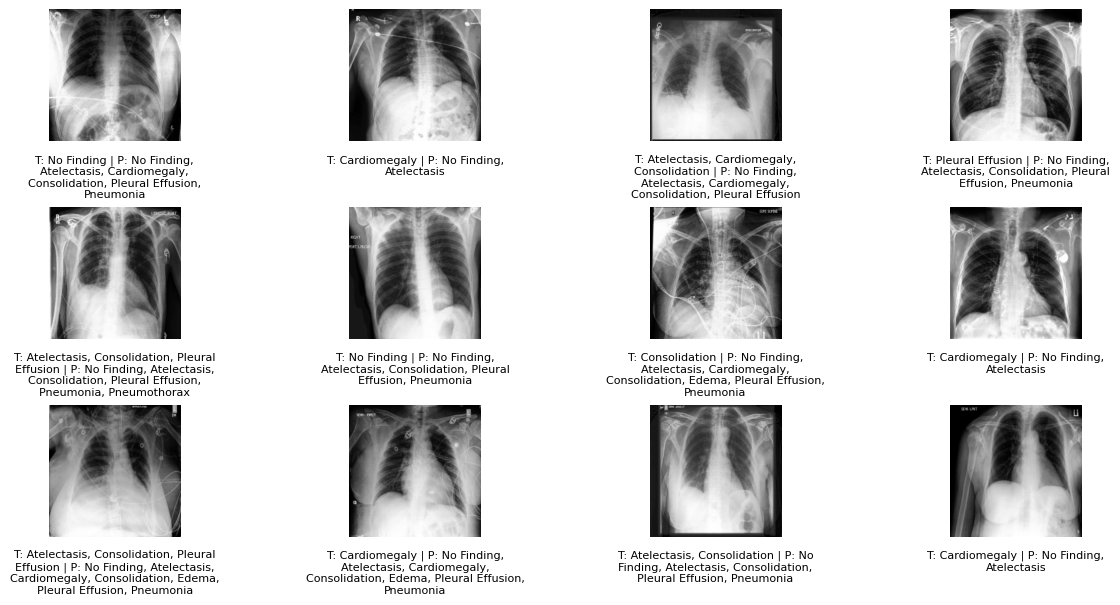

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

#### Vision Transformer(ViT_b_16)

In [ ]:
def test_acc_best_model_vit(CHECKPOINT_DIR, num_classes,test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model = build_vit_b_16(num_classes,False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()
  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")
  # Testing
  test_corrects,total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc, best_model

In [ ]:
def test_acc_ckpt_vit(CHECKPOINT_DIR,num_classes,test_loader,ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_vit_b_16(num_classes, False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects,total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs > 0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels

  return test_acc, model

In [ ]:
vit_CHECKPOINT_DIR = os.path.join(EE782, 'vit_b_16_checkpoints')
os.makedirs(vit_CHECKPOINT_DIR, exist_ok = True)

In [ ]:
vit_b_16_model    = build_vit_b_16(num_classes)
vit_b_16_model    = vit_b_16_model.to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:04<00:00, 69.8MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(vit_b_16_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train(vit_CHECKPOINT_DIR, vit_b_16_model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 509/509 [09:34<00:00,  1.13s/it]


Train Loss: 0.4029 | Train Accuracy: 0.8226



Val Epoch 1: 100%|██████████| 89/89 [00:33<00:00,  2.67it/s]


Validation Loss: 0.3967 | Validation Accuracy: 0.8326

New best model saved at epoch 1 with val accuracy = 0.8326

----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 509/509 [09:45<00:00,  1.15s/it]


Train Loss: 0.3642 | Train Accuracy: 0.8383



Val Epoch 2: 100%|██████████| 89/89 [00:33<00:00,  2.66it/s]


Validation Loss: 0.3493 | Validation Accuracy: 0.8443

New best model saved at epoch 2 with val accuracy = 0.8443

----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 509/509 [09:45<00:00,  1.15s/it]


Train Loss: 0.3457 | Train Accuracy: 0.8486



Val Epoch 3: 100%|██████████| 89/89 [00:33<00:00,  2.65it/s]


Validation Loss: 0.3452 | Validation Accuracy: 0.8555

New best model saved at epoch 3 with val accuracy = 0.8555

----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 509/509 [09:46<00:00,  1.15s/it]


Train Loss: 0.3244 | Train Accuracy: 0.8594



Val Epoch 4: 100%|██████████| 89/89 [00:34<00:00,  2.61it/s]


Validation Loss: 0.3608 | Validation Accuracy: 0.8476

----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 509/509 [09:45<00:00,  1.15s/it]


Train Loss: 0.3114 | Train Accuracy: 0.8653



Val Epoch 5: 100%|██████████| 89/89 [00:33<00:00,  2.68it/s]


Validation Loss: 0.3502 | Validation Accuracy: 0.8482

----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 509/509 [09:50<00:00,  1.16s/it]


Train Loss: 0.2948 | Train Accuracy: 0.8737



Val Epoch 6: 100%|██████████| 89/89 [00:33<00:00,  2.68it/s]


Validation Loss: 0.3705 | Validation Accuracy: 0.8434

----------------- Epoch 7 -----------------


Train Epoch 7: 100%|██████████| 509/509 [09:40<00:00,  1.14s/it]


Train Loss: 0.2743 | Train Accuracy: 0.8846



Val Epoch 7: 100%|██████████| 89/89 [00:33<00:00,  2.70it/s]


Validation Loss: 0.3636 | Validation Accuracy: 0.8458

----------------- Epoch 8 -----------------


Train Epoch 8: 100%|██████████| 509/509 [09:43<00:00,  1.15s/it]


Train Loss: 0.2422 | Train Accuracy: 0.8978



Val Epoch 8: 100%|██████████| 89/89 [00:33<00:00,  2.66it/s]


Validation Loss: 0.3904 | Validation Accuracy: 0.8467


Early stopping. No improvement in 5 epochs

Training complete. Best validation accuracy: 0.8555 at epoch 3


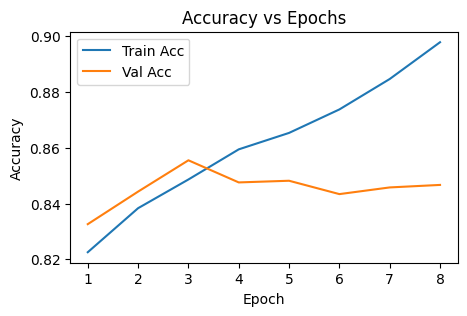

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_vit(vit_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 3 with val acc = 0.8555
Test Label-wise Accuracy: 52.1040 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.556 | AP: 0.133
Atelectasis          | AUC: 0.727 | AP: 0.524
Cardiomegaly         | AUC: 0.735 | AP: 0.540
Consolidation        | AUC: 0.809 | AP: 0.835
Edema                | AUC: 0.838 | AP: 0.661
Pleural Effusion     | AUC: 0.818 | AP: 0.699
Pneumonia            | AUC: 0.781 | AP: 0.223
Pneumothorax         | AUC: 0.587 | AP: 0.074

------ Summary ------ 
Mean AUC: 0.731
Mean AP:  0.461
Macro F1: 0.412
Micro F1: 0.495


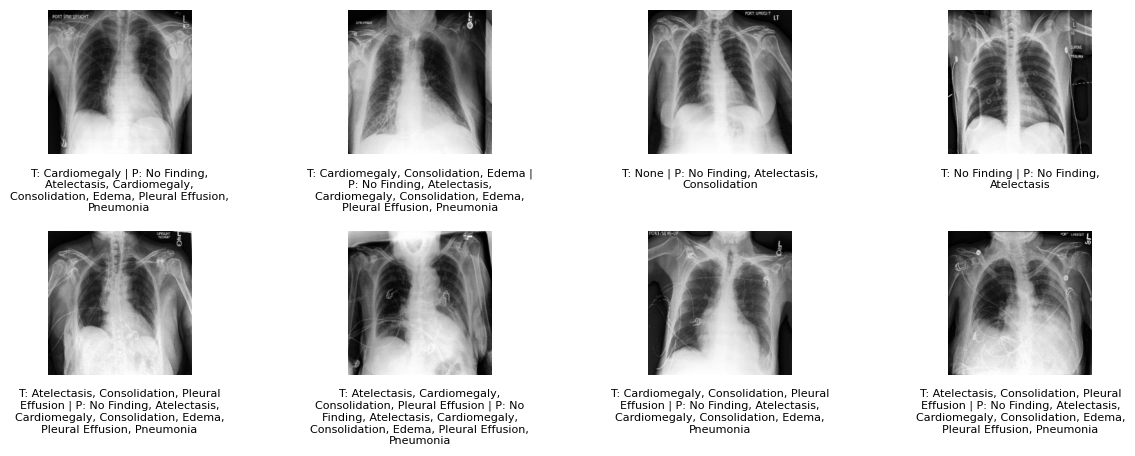

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=8)

In [ ]:
t2, ckpt_model = test_acc_ckpt_vit(vit_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=8)
print(f"Test Label-wise Accuracy: {t2*100:.4f} %")


Loaded model from epoch 8
Test Label-wise Accuracy: 50.8663 %


---

In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.744 | AP: 0.243
Atelectasis          | AUC: 0.750 | AP: 0.608
Cardiomegaly         | AUC: 0.789 | AP: 0.662
Consolidation        | AUC: 0.819 | AP: 0.848
Edema                | AUC: 0.846 | AP: 0.681
Pleural Effusion     | AUC: 0.831 | AP: 0.735
Pneumonia            | AUC: 0.773 | AP: 0.267
Pneumothorax         | AUC: 0.598 | AP: 0.053

------ Summary ------ 
Mean AUC: 0.769
Mean AP:  0.512
Macro F1: 0.418
Micro F1: 0.486


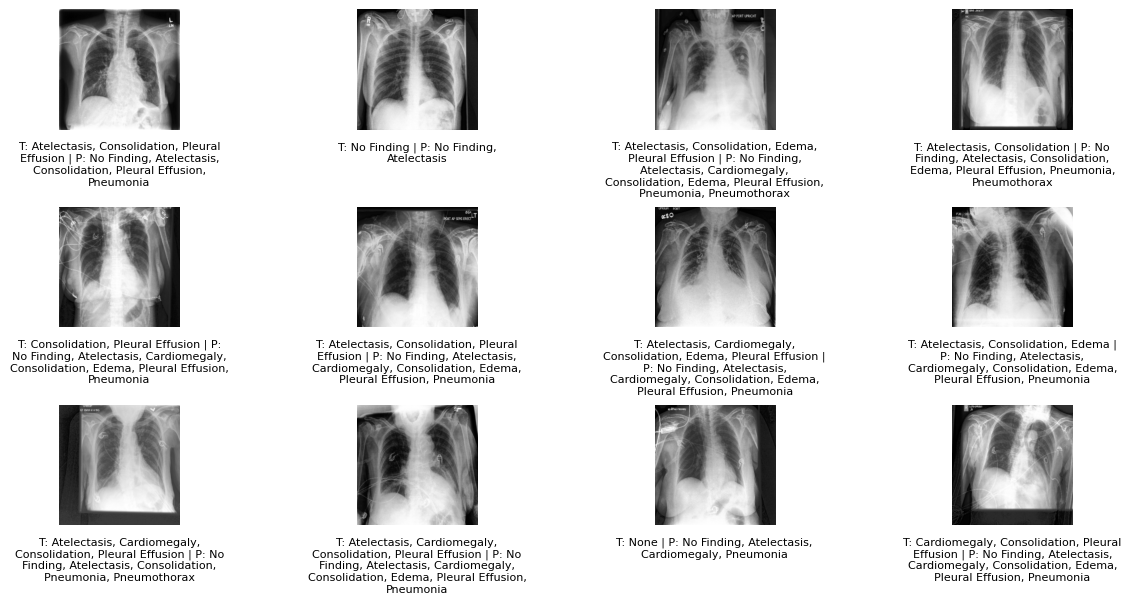

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

#### ConvNeXt-Tiny


In [ ]:
def test_acc_best_model_convnext(CHECKPOINT_DIR ,num_classes, test_loader):

  best_model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
  best_model = build_convnext(num_classes, False)

  checkpoint = torch.load(best_model_path, map_location=device)
  best_model.load_state_dict(checkpoint['model_state_dict'])
  best_model.to(device)
  best_model.eval()

  print(f"Loaded best model from epoch {checkpoint['best_epoch']} with val acc = {checkpoint['best_val_acc']:.4f}")
  # Testing
  test_corrects = 0
  total_test_labels = 0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = best_model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc, best_model

In [ ]:
def test_acc_ckpt_convnext(CHECKPOINT_DIR, num_classes, test_loader, ckpt_epoch):

  ckpt_model_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{ckpt_epoch}.pth")
  model = build_convnext(num_classes, False)

  # Load the checkpoint
  checkpoint = torch.load(ckpt_model_path, map_location=device)
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  model.eval()
  print(f"Loaded model from epoch {checkpoint['epoch']}")

  # Testing
  test_corrects, total_test_labels = 0,0
  with torch.no_grad():
      for images, labels, masks in test_loader:
          images, labels, masks = images.to(device), labels.to(device), masks.to(device)
          outputs = model(images).to(device)
          probs = torch.sigmoid(outputs)
          preds = (probs>0.5).float()
          test_corrects += ((preds==labels)*masks).sum()
          total_test_labels += masks.sum()

  test_acc = test_corrects.double() / total_test_labels
  return test_acc, model

In [ ]:
convnext_CHECKPOINT_DIR = os.path.join(EE782, "convnext_checkpoints")
os.makedirs(convnext_CHECKPOINT_DIR, exist_ok = True)

In [ ]:
convnext_model    = build_convnext(num_classes)
convnext_model    = convnext_model.to(device)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 118MB/s]


In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction="none")  # reduction='none' for mask handling
optimizer = torch.optim.AdamW(convnext_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

In [ ]:
metrics =  train(convnext_CHECKPOINT_DIR, convnext_model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=20, resume_epoch=None)

----------------- Epoch 1 -----------------


Train Epoch 1: 100%|██████████| 509/509 [06:42<00:00,  1.26it/s]


Train Loss: 0.3510 | Train Accuracy: 0.8469



Val Epoch 1: 100%|██████████| 89/89 [00:18<00:00,  4.80it/s]


Validation Loss: 0.3147 | Validation Accuracy: 0.8625

New best model saved at epoch 1 with val accuracy = 0.8625

----------------- Epoch 2 -----------------


Train Epoch 2: 100%|██████████| 509/509 [06:38<00:00,  1.28it/s]


Train Loss: 0.3015 | Train Accuracy: 0.8706



Val Epoch 2: 100%|██████████| 89/89 [00:15<00:00,  5.90it/s]


Validation Loss: 0.3056 | Validation Accuracy: 0.8701

New best model saved at epoch 2 with val accuracy = 0.8701

----------------- Epoch 3 -----------------


Train Epoch 3: 100%|██████████| 509/509 [06:37<00:00,  1.28it/s]


Train Loss: 0.2684 | Train Accuracy: 0.8874



Val Epoch 3: 100%|██████████| 89/89 [00:16<00:00,  5.47it/s]


Validation Loss: 0.3101 | Validation Accuracy: 0.8748

New best model saved at epoch 3 with val accuracy = 0.8748

----------------- Epoch 4 -----------------


Train Epoch 4: 100%|██████████| 509/509 [06:35<00:00,  1.29it/s]


Train Loss: 0.2289 | Train Accuracy: 0.9077



Val Epoch 4: 100%|██████████| 89/89 [00:16<00:00,  5.49it/s]


Validation Loss: 0.3189 | Validation Accuracy: 0.8671

----------------- Epoch 5 -----------------


Train Epoch 5: 100%|██████████| 509/509 [06:36<00:00,  1.28it/s]


Train Loss: 0.1713 | Train Accuracy: 0.9356



Val Epoch 5: 100%|██████████| 89/89 [00:16<00:00,  5.32it/s]


Validation Loss: 0.3416 | Validation Accuracy: 0.8728

----------------- Epoch 6 -----------------


Train Epoch 6: 100%|██████████| 509/509 [06:37<00:00,  1.28it/s]


Train Loss: 0.1173 | Train Accuracy: 0.9586



Val Epoch 6: 100%|██████████| 89/89 [00:15<00:00,  5.87it/s]


Validation Loss: 0.4561 | Validation Accuracy: 0.8485

----------------- Epoch 7 -----------------


Train Epoch 7: 100%|██████████| 509/509 [06:38<00:00,  1.28it/s]


Train Loss: 0.0753 | Train Accuracy: 0.9742



Val Epoch 7: 100%|██████████| 89/89 [00:16<00:00,  5.51it/s]


Validation Loss: 0.4195 | Validation Accuracy: 0.8537

----------------- Epoch 8 -----------------


Train Epoch 8: 100%|██████████| 509/509 [06:37<00:00,  1.28it/s]


Train Loss: 0.0474 | Train Accuracy: 0.9853



Val Epoch 8: 100%|██████████| 89/89 [00:15<00:00,  5.89it/s]


Validation Loss: 0.4560 | Validation Accuracy: 0.8677


Early stopping. No improvement in 5 epochs

Training complete. Best validation accuracy: 0.8748 at epoch 3


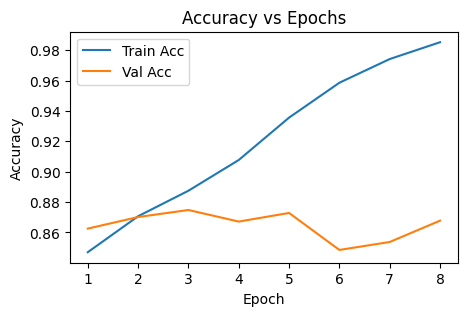

In [ ]:
plot_train_val_acc(metrics)

In [ ]:
t1, best_model = test_acc_best_model_convnext(convnext_CHECKPOINT_DIR, num_classes, chexpert_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 3 with val acc = 0.8748
Test Label-wise Accuracy: 56.9926 %


In [ ]:
classes = train_dataset.classes
evaluate_model(best_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.778 | AP: 0.258
Atelectasis          | AUC: 0.822 | AP: 0.672
Cardiomegaly         | AUC: 0.797 | AP: 0.646
Consolidation        | AUC: 0.892 | AP: 0.910
Edema                | AUC: 0.879 | AP: 0.715
Pleural Effusion     | AUC: 0.899 | AP: 0.832
Pneumonia            | AUC: 0.848 | AP: 0.218
Pneumothorax         | AUC: 0.723 | AP: 0.172

------ Summary ------ 
Mean AUC: 0.830
Mean AP:  0.553
Macro F1: 0.460
Micro F1: 0.518


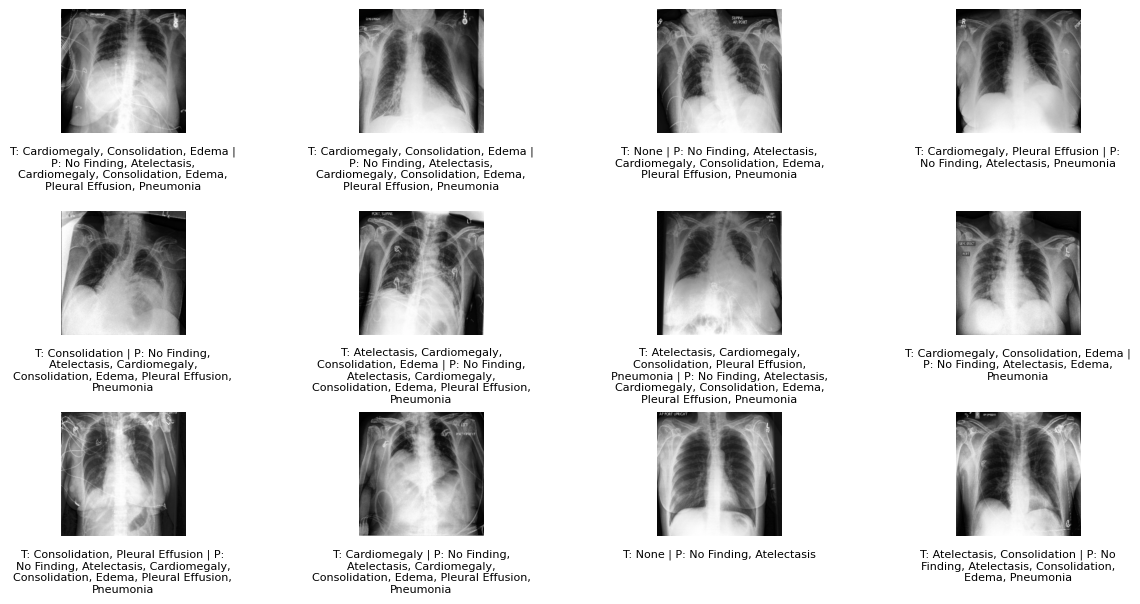

In [ ]:
visualize_predictions(best_model, chexpert_test_loader, device, classes, num_images=12)

---

In [ ]:
t2, ckpt_model= test_acc_ckpt_convnext(convnext_CHECKPOINT_DIR, num_classes, chexpert_test_loader, ckpt_epoch=8)
print(f"Test Accuracy: {t2*100:.4f} %"),

Loaded model from epoch 8
Test Accuracy: 60.2104 %


(None,)

In [ ]:
classes = train_dataset.classes
evaluate_model(ckpt_model, chexpert_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.680 | AP: 0.206
Atelectasis          | AUC: 0.806 | AP: 0.706
Cardiomegaly         | AUC: 0.799 | AP: 0.617
Consolidation        | AUC: 0.862 | AP: 0.880
Edema                | AUC: 0.879 | AP: 0.663
Pleural Effusion     | AUC: 0.902 | AP: 0.806
Pneumonia            | AUC: 0.762 | AP: 0.096
Pneumothorax         | AUC: 0.751 | AP: 0.117

------ Summary ------ 
Mean AUC: 0.805
Mean AP:  0.511
Macro F1: 0.478
Micro F1: 0.534


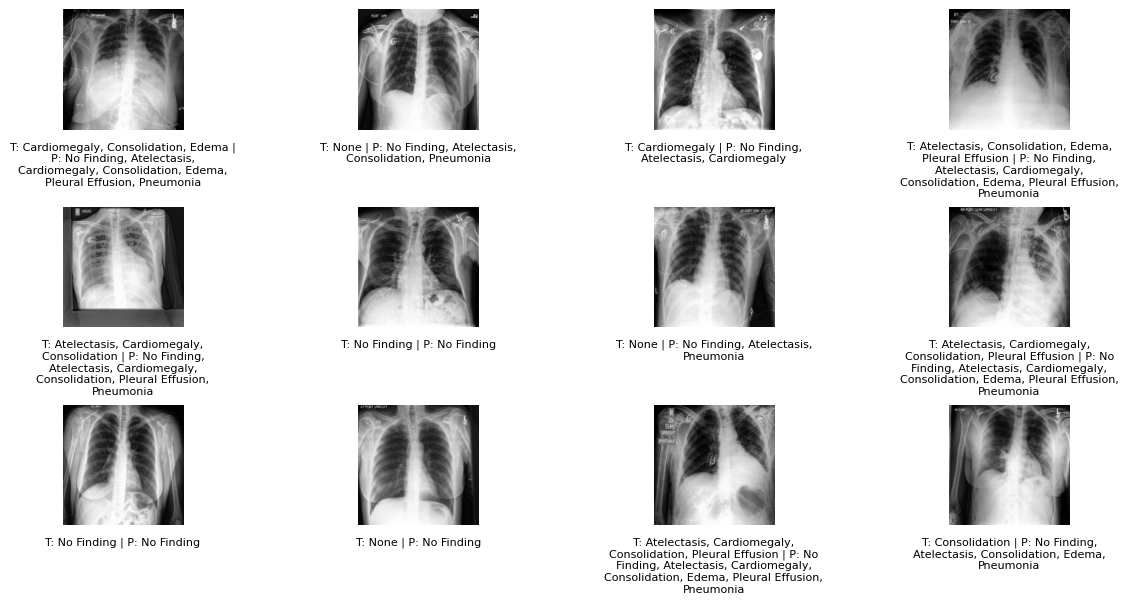

In [ ]:
visualize_predictions(ckpt_model, chexpert_test_loader, device, classes, num_images=12)

### Testing on other dataset(NIH ChestX-ray14)

#### NIH Chest X-Rays

##### Data

In [ ]:
NIH_DATA    = os.path.join(EE782, 'NIH_DATA')
NIH_CSV     = os.path.join(EE782, 'NIH_DATA/Data_Entry_2017.csv')
NIH_IMG_DIR = os.path.join(EE782, 'NIH_DATA/images_001/images')

In [ ]:
files = os.listdir(NIH_IMG_DIR)
len(files)

4999

In [ ]:
nih_df = pd.read_csv(NIH_CSV)
nih_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [ ]:
len(nih_df)

112120

* Considering only the images in the "images_001" folder for testing

In [ ]:
img_dir_files   = set(os.listdir(NIH_IMG_DIR))

In [ ]:
filtered_nih_df = nih_df[nih_df["Image Index"].isin(img_dir_files)].copy()

In [ ]:
filtered_nih_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [ ]:
len(filtered_nih_df)

4999

In [ ]:
# updating the "Image Index" column with image path
PATH_COL = "Image Index"
filtered_nih_df[PATH_COL] = filtered_nih_df[PATH_COL].apply(lambda fn: os.path.join(NIH_IMG_DIR, fn))

In [ ]:
filtered_nih_df.head()

Image Index          Finding Labels  \
0  /content/drive/MyDrive/EE782/NIH_DATA/images_0...            Cardiomegaly   
1  /content/drive/MyDrive/EE782/NIH_DATA/images_0...  Cardiomegaly|Emphysema   
2  /content/drive/MyDrive/EE782/NIH_DATA/images_0...   Cardiomegaly|Effusion   
3  /content/drive/MyDrive/EE782/NIH_DATA/images_0...              No Finding   
4  /content/drive/MyDrive/EE782/NIH_DATA/images_0...                  Hernia   

   Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
0            0           1           58              M            PA   
1            1           1           58              M            PA   
2            2           1           58              M            PA   
3            0           2           81              M            PA   
4            0           3           81              F            PA   

   OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
0                 2682     2749                        0.143  0.143   
1                 2894     2729                        0.143  0.143   
2                 2500     2048                        0.168  0.168   
3                 2500     2048                        0.171  0.171   
4                 2582     2991                        0.143  0.143   

   Unnamed: 11  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [ ]:
# NIH stores labels in a single string column "Finding Labels" (common), expanding them:
if "Finding Labels" in filtered_nih_df.columns and not any(c in filtered_nih_df.columns for c in nih_to_canon.keys()):

    # create one-hot columns from "Finding Labels" (strings like "Cardiomegaly|Effusion")
    filtered_nih_df["Finding Labels"] = filtered_nih_df["Finding Labels"].fillna("")
    for src in nih_to_canon.keys():
        filtered_nih_df[src] = filtered_nih_df["Finding Labels"].apply(lambda s: 1.0 if src in s.split("|") else 0.0)

In [ ]:
filtered_nih_df.head()

Image Index          Finding Labels  \
0  /content/drive/MyDrive/EE782/NIH_DATA/images_0...            Cardiomegaly   
1  /content/drive/MyDrive/EE782/NIH_DATA/images_0...  Cardiomegaly|Emphysema   
2  /content/drive/MyDrive/EE782/NIH_DATA/images_0...   Cardiomegaly|Effusion   
3  /content/drive/MyDrive/EE782/NIH_DATA/images_0...              No Finding   
4  /content/drive/MyDrive/EE782/NIH_DATA/images_0...                  Hernia   

   Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
0            0           1           58              M            PA   
1            1           1           58              M            PA   
2            2           1           58              M            PA   
3            0           2           81              M            PA   
4            0           3           81              F            PA   

   OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
0                 2682     2749                        0.143  0.143   
1                 2894     2729                        0.143  0.143   
2                 2500     2048                        0.168  0.168   
3                 2500     2048                        0.171  0.171   
4                 2582     2991                        0.143  0.143   

   Unnamed: 11  No Finding  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0          NaN         0.0          0.0           1.0            0.0    0.0   
1          NaN         0.0          0.0           1.0            0.0    0.0   
2          NaN         0.0          0.0           1.0            0.0    0.0   
3          NaN         1.0          0.0           0.0            0.0    0.0   
4          NaN         0.0          0.0           0.0            0.0    0.0   

   Effusion  Pneumonia  Pneumothorax  
0       0.0        0.0           0.0  
1       0.0        0.0           0.0  
2       1.0        0.0           0.0  
3       0.0        0.0           0.0  
4       0.0        0.0           0.0

In [ ]:
# making NIH canonical dataframe
nih_canon_df = make_canonical_df(filtered_nih_df, nih_to_canon, canonical, path_col=PATH_COL)
nih_canon_df.head()

Path  No Finding  \
0  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   
1  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   
2  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   
3  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         1.0   
4  /content/drive/MyDrive/EE782/NIH_DATA/images_0...         0.0   

   No Finding_mask  Atelectasis  Atelectasis_mask  Cardiomegaly  \
0                1          0.0                 1           1.0   
1                1          0.0                 1           1.0   
2                1          0.0                 1           1.0   
3                1          0.0                 1           0.0   
4                1          0.0                 1           0.0   

   Cardiomegaly_mask  Consolidation  Consolidation_mask  Edema  Edema_mask  \
0                  1            0.0                   1    0.0           1   
1                  1            0.0                   1    0.0           1   
2                  1            0.0                   1    0.0           1   
3                  1            0.0                   1    0.0           1   
4                  1            0.0                   1    0.0           1   

   Pleural Effusion  Pleural Effusion_mask  Pneumonia  Pneumonia_mask  \
0               0.0                      1        0.0               1   
1               0.0                      1        0.0               1   
2               1.0                      1        0.0               1   
3               0.0                      1        0.0               1   
4               0.0                      1        0.0               1   

   Pneumothorax  Pneumothorax_mask  
0           0.0                  1  
1           0.0                  1  
2           0.0                  1  
3           0.0                  1  
4           0.0                  1

In [ ]:
nih_canon_df.to_excel(os.path.join(NIH_DATA,'nih_canon_df.xlsx'), index=False)
print("DataFrame saved as 'nih_canon_df.xlsx'")

DataFrame saved as 'nih_canon_df.xlsx'


In [ ]:
# label prevalence
for c in canonical:
    valid = nih_canon_df[c + "_mask"].sum()
    positives = nih_canon_df[c].sum()
    print(f"{c:20s} | labeled: {int(valid):6d} | positives: {int(positives):6d} | prevalence: {positives/valid if valid>0 else np.nan:.3f}")

No Finding           | labeled:   4999 | positives:   2754 | prevalence: 0.551
Atelectasis          | labeled:   4999 | positives:    460 | prevalence: 0.092
Cardiomegaly         | labeled:   4999 | positives:    196 | prevalence: 0.039
Consolidation        | labeled:   4999 | positives:    205 | prevalence: 0.041
Edema                | labeled:   4999 | positives:     90 | prevalence: 0.018
Pleural Effusion     | labeled:   4999 | positives:    487 | prevalence: 0.097
Pneumonia            | labeled:   4999 | positives:     65 | prevalence: 0.013
Pneumothorax         | labeled:   4999 | positives:    199 | prevalence: 0.040


##### Custom Dataset Class

In [ ]:
class NIH_Dataset(Dataset):
    def __init__(self, df, transform=None, target_cols=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.target_cols = target_cols
        self.mask_cols = [c + "_mask" for c in target_cols]
        self.classes = target_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["Path"]
        image = Image.open(img_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row[self.target_cols].to_numpy(dtype=np.float32))
        mask = torch.tensor(row[self.mask_cols].to_numpy(dtype=np.float32))
        return image, label, mask

##### DataLoader

In [ ]:
nih_canon_df_pth = os.path.join(NIH_DATA,'nih_canon_df.xlsx')
nih_canon_df = pd.read_excel(nih_canon_df_pth)

In [ ]:
len(nih_canon_df)

4999

In [ ]:
nih_data_small = nih_canon_df.sample(frac=0.1, random_state=SEED).reset_index(drop=True)

In [ ]:
len(nih_data_small)

500

In [ ]:
nih_dataset      = NIH_Dataset(nih_data_small, transform=val_transforms, target_cols=canonical)
nih_test_loader  = DataLoader(nih_dataset, batch_size=32, shuffle=False,num_workers=2, pin_memory=True)

In [ ]:
img, labels, mask = next(iter(nih_test_loader))
print(img.shape)
print(labels.shape)
print(mask.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 8])
torch.Size([32, 8])


#### Testing

In [ ]:
num_classes = len(canonical)
num_classes

8

In [ ]:
SEED = 123

##### ResNet50

In [ ]:
resnet50_CHECKPOINT_DIR = os.path.join(EE782, f'resnet50_checkpoints_seed_{SEED}')

In [ ]:
t1, best_model = test_acc_best_model_resnet50(resnet50_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 3 with val acc = 0.8676
Test Label-wise Accuracy: 54.1000 %


In [ ]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.646 | AP: 0.706
Atelectasis          | AUC: 0.678 | AP: 0.162
Cardiomegaly         | AUC: 0.779 | AP: 0.109
Consolidation        | AUC: 0.682 | AP: 0.070
Edema                | AUC: 0.924 | AP: 0.270
Pleural Effusion     | AUC: 0.835 | AP: 0.290
Pneumonia            | AUC: 0.626 | AP: 0.045
Pneumothorax         | AUC: 0.747 | AP: 0.168

------ Summary ------ 
Mean AUC: 0.740
Mean AP:  0.228
Macro F1: 0.215
Micro F1: 0.310


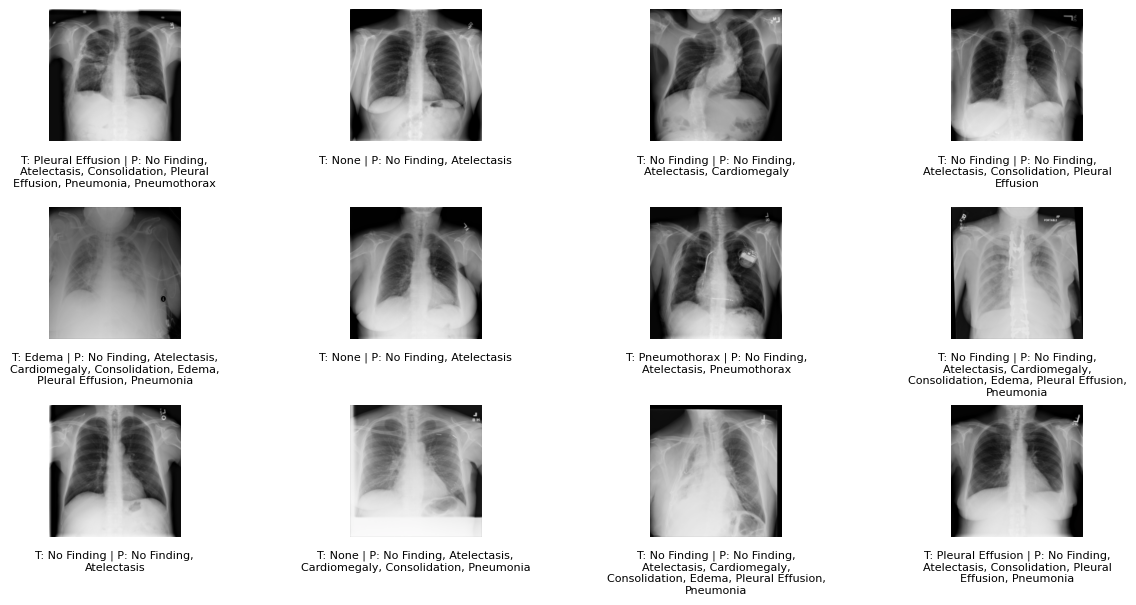

In [ ]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)

##### DenseNet121

In [ ]:
densenet121_CHECKPOINT_DIR = os.path.join(EE782, f'densenet121_checkpoints_seed_{SEED}')

In [ ]:
t1, best_model = test_acc_best_model_densenet121(densenet121_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 3 with val acc = 0.8689
Test Label-wise Accuracy: 55.8750 %


In [ ]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.657 | AP: 0.692
Atelectasis          | AUC: 0.634 | AP: 0.132
Cardiomegaly         | AUC: 0.838 | AP: 0.200
Consolidation        | AUC: 0.712 | AP: 0.086
Edema                | AUC: 0.947 | AP: 0.270
Pleural Effusion     | AUC: 0.855 | AP: 0.309
Pneumonia            | AUC: 0.627 | AP: 0.097
Pneumothorax         | AUC: 0.753 | AP: 0.162

------ Summary ------ 
Mean AUC: 0.753
Mean AP:  0.244
Macro F1: 0.234
Micro F1: 0.319


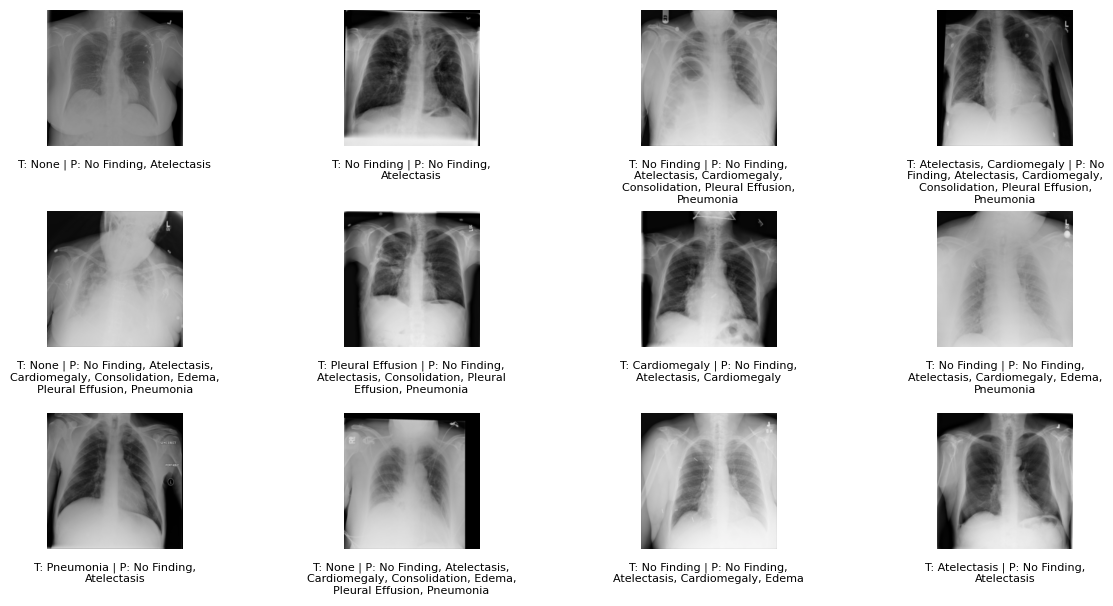

In [ ]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)

##### Vision Transformer(ViT_b_16)

In [ ]:
vit_CHECKPOINT_DIR = os.path.join(EE782, f'vit_b_16_checkpoints_seed_{SEED}')

In [ ]:
t1, best_model = test_acc_best_model_vit(vit_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Loaded best model from epoch 3 with val acc = 0.8555
Test Label-wise Accuracy: 52.1750 %


In [ ]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.581 | AP: 0.584
Atelectasis          | AUC: 0.639 | AP: 0.142
Cardiomegaly         | AUC: 0.797 | AP: 0.118
Consolidation        | AUC: 0.699 | AP: 0.107
Edema                | AUC: 0.895 | AP: 0.216
Pleural Effusion     | AUC: 0.818 | AP: 0.259
Pneumonia            | AUC: 0.568 | AP: 0.038
Pneumothorax         | AUC: 0.622 | AP: 0.049

------ Summary ------ 
Mean AUC: 0.702
Mean AP:  0.189
Macro F1: 0.194
Micro F1: 0.300


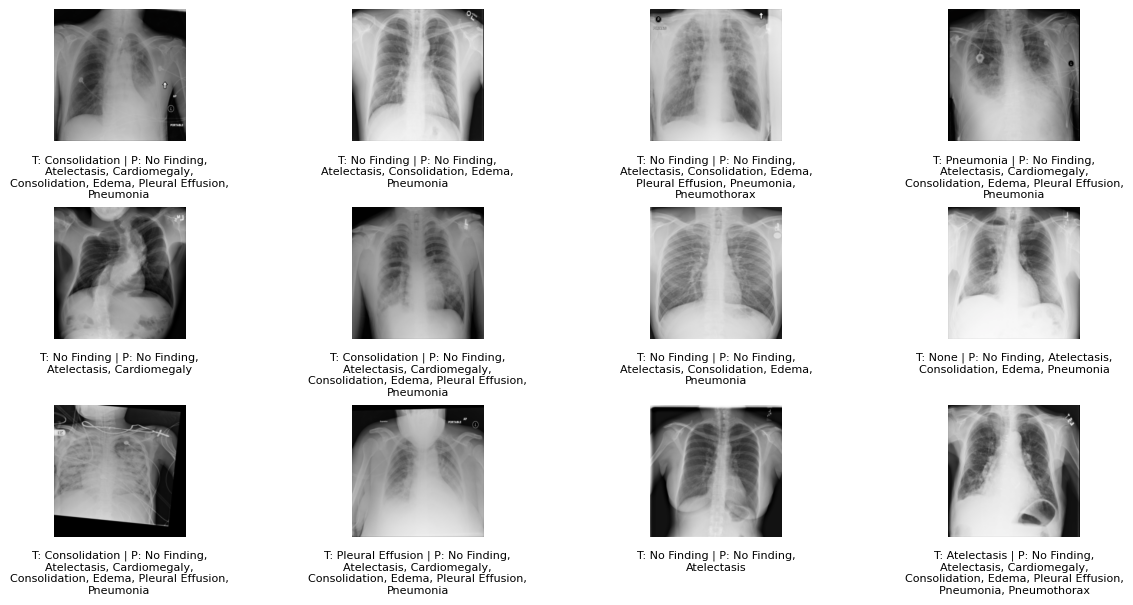

In [ ]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)

##### ConvNeXt-Tiny

In [ ]:
convnext_CHECKPOINT_DIR = os.path.join(EE782, f"convnext_checkpoints_seed_{SEED}")

In [ ]:
t1, best_model = test_acc_best_model_convnext(convnext_CHECKPOINT_DIR, num_classes, nih_test_loader)
print(f"Test Label-wise Accuracy: {t1*100:.4f} %")

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 142MB/s]


Loaded best model from epoch 3 with val acc = 0.8748
Test Label-wise Accuracy: 59.7250 %


In [ ]:
classes = nih_dataset.classes
evaluate_model(best_model, nih_test_loader, device, classes)

------ Per-Class Metrics ------ 
No Finding           | AUC: 0.639 | AP: 0.642
Atelectasis          | AUC: 0.687 | AP: 0.192
Cardiomegaly         | AUC: 0.872 | AP: 0.277
Consolidation        | AUC: 0.738 | AP: 0.109
Edema                | AUC: 0.951 | AP: 0.381
Pleural Effusion     | AUC: 0.873 | AP: 0.402
Pneumonia            | AUC: 0.641 | AP: 0.041
Pneumothorax         | AUC: 0.664 | AP: 0.080

------ Summary ------ 
Mean AUC: 0.758
Mean AP:  0.266
Macro F1: 0.214
Micro F1: 0.335


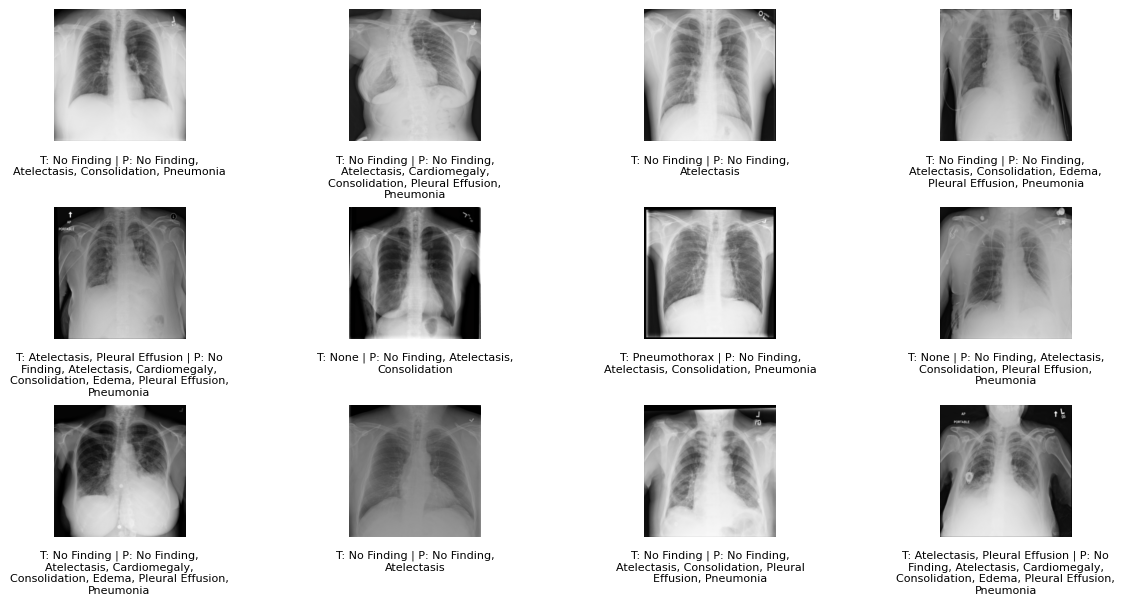

In [ ]:
visualize_predictions(best_model, nih_test_loader, device, classes, num_images=12)